In [40]:

import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'/global/homes/b/bpb/repos/scndb/')
import scndb.tools as wt

import networkx as nx

from rdkit.Chem import rdFMCS
from rdkit.Chem import MolFromSmiles, MolFromSmarts
from rdkit.Chem.Draw import MolsToGridImage

import shutil

from scipy.cluster import hierarchy
from multiprocessing import Pool

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.read_graphml('CarbonNetwork.graphml')
import networkx as nx


In [42]:
# df = G.nodes(data=True)
# df = pd.DataFrame(df, columns=['node_id', 'data'])
# df.set_index('node_id', inplace=True)
# df = df['data'].apply(pd.Series)

# p = wt.get_formula_props(df,formula_key='predicted_formula')
# df = pd.merge(df,p,left_on='predicted_formula',right_on='formula',how='left')


In [43]:
# def replace_list_identifiers(df,G,identifier='class_results'):
#     temp = df.loc[pd.notna(df[identifier]),identifier].tolist()
#     temp = [x.split(',') for x in temp]
#     temp = [item for sublist in temp for item in sublist]
#     temp = pd.Series(temp)
#     pathway_counts = temp.value_counts()
#     for i,row in df[pd.notna(df[identifier])].iterrows():
#         split_results = row[identifier].split(',')
#         if len(split_results) > 1:
#             d = {}
#             for r in split_results:
#                 d[r] = pathway_counts[r]
#             df.at[i, identifier] = max(d, key=d.get)

#     nx.set_node_attributes(G, df[identifier].to_dict(), identifier)
#     return G

# G = replace_list_identifiers(df,G,identifier='class_results')
# G = replace_list_identifiers(df,G,identifier='pathway_results')
# G = replace_list_identifiers(df,G,identifier='superclass_results')



In [44]:
import pandas as pd
G_mst = nx.maximum_spanning_tree(G)
print(len(G.edges), len(G_mst.edges))
# highest_degree = max(G_mst.degree(), key=lambda x: x[1])
# print("Highest node degree in G_mst:", highest_degree)

# removed_edges = list(set(G.edges) - set(G_mst.edges))
# removed_edge_data = [G.edges[edge] for edge in removed_edges]

# df_removed_edges = pd.DataFrame(removed_edges, columns=['Source', 'Target'])
# df_removed_edge_data = pd.DataFrame(removed_edge_data, columns=['rem_blink_score'])

# df_removed_edges_with_data = pd.concat([df_removed_edges, df_removed_edge_data], axis=1)

# df_removed_edges_with_data.sort_values('rem_blink_score', ascending=False, inplace=True)
# df_removed_edges_with_data.reset_index(drop=True, inplace=True)
# idx = df_removed_edges_with_data['rem_blink_score']>0.2
# for i,row in df_removed_edges_with_data[idx].iterrows():
#     G_mst.add_edge(row['Source'], row['Target'], rem_predicted_score=row['rem_blink_score'])


# # top_edge = df_removed_edges_with_data.iloc[0]
# # G_mst.add_edge(top_edge['Source'], top_edge['Target'], rem_predicted_score=top_edge['rem_predicted_score'])

# highest_degree = max(G_mst.degree(), key=lambda x: x[1])
# median_degree = np.median(list(dict(G_mst.degree()).values()))
# print("Highest node degree in G_mst:", highest_degree,median_degree)


# print(len(G.edges), len(G_mst.edges))

48261 7098


In [45]:

# Get the connected components in the graph
components = list(nx.connected_components(G_mst))

# Filter out subgraphs with less than 1000 nodes
filtered_components = [component for component in components if len(component) >= 1000]

# Create a new graph
G_filtered = nx.Graph()

# Add each subgraph to the new graph
for component in filtered_components:
    G_filtered = nx.compose(G_filtered, G_mst.subgraph(component))


In [46]:

pos = nx.nx_agraph.graphviz_layout(G_filtered, prog='neato')



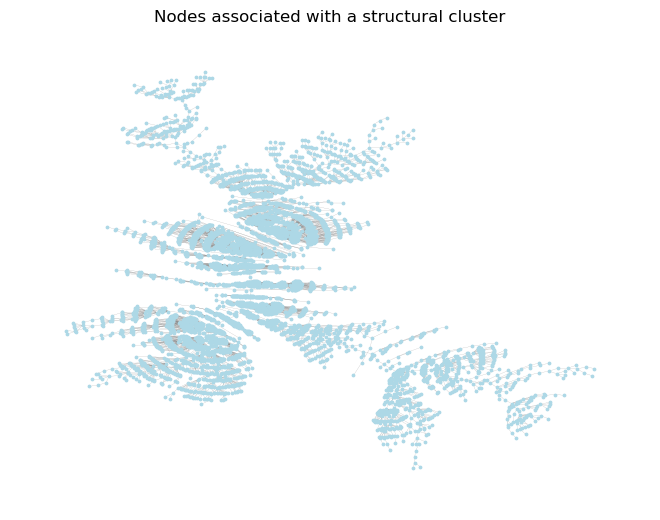

In [47]:
nx.draw(G_filtered, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=3, edge_color='gray', width=0.1)
plt.title("Nodes associated with a structural cluster")
plt.show()

In [48]:
for node, (x, y) in pos.items():
    G_filtered.nodes[node]['x'] = x
    G_filtered.nodes[node]['y'] = y
nx.write_graphml(G_filtered, 'CarbonNetwork_mst_with-positions.graphml')

In [ ]:
# import sys
# import pandas as pd
# sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas/')
# from metatlas.interfaces import classyfire_tools as cf
# filename = '/global/homes/b/bpb/repos/scndb/data/ringtrial_ema_class.csv'
# df = pd.read_csv(filename)
# inchi_keys = df['inchi_key'].values
# df = cf.get_classyfire_classes(inchi_keys)
# df.to_csv('/global/homes/b/bpb/repos/scndb/data/ringtrial_ema_classyfire_class.csv',index=False)


In [ ]:

mz_tol = 0.002
similarity_cutoff = 0.8
isolation_tol = 0.5
min_intensity_ratio=2 #minimum intensity ratio between sum of fragments between two spectra
my_polarity = 'negative' #either 'positive' or 'negative'

deltas = pd.read_csv('../data/mdm_neutral_losses.csv')

# file = '/pscratch/sd/b/bpb/data_for_wave-database'
file = '/global/cfs/cdirs/metatlas/projects/rawdata_for_scn'
files = glob.glob(os.path.join(file,'*.h5'))
files = [f for f in files if not 'exctrl' in f.lower()]
files = [f for f in files if not 'qc' in f.lower()]


file = '/global/cfs/cdirs/metatlas/projects/massive_data_for_scn'
files_massive = glob.glob(os.path.join(file,'*.h5'))
files_massive = [f for f in files_massive if not 'exctrl' in f.lower()]
files_massive = [f for f in files_massive if not 'qc' in f.lower()]

files = files + files_massive

print(len(files))

ft_df = pd.read_csv('../data/Zark_Dittmar_DOM_molec-comp.tab',sep='\t',skiprows=19)
ft_df.rename(columns = {'m/z':'mz', 'Formula ("no reference" refers to dete...)':'formula'},inplace=True)
ft_df.columns = [c.lower().replace('(','').replace(')','') for c in ft_df.columns]
ft_df.columns = [c.replace(' ','_') for c in ft_df.columns]
ft_df = ft_df[ft_df['formula'] != 'no reference']
print(ft_df.shape)
ft_df.head()

In [ ]:
max_rt = 1000
df = []
for f in files:
    temp = wt.run_wave_workflow(f,
                                deltas,
                                mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                isolation_tol=isolation_tol,
                                my_polarity=my_polarity,
                                do_buddy=True,
                                max_rt=max_rt,
                                ft_icr_filter=None)
    if temp is not None:
        df.append(temp)

In [ ]:
df[0].columns

In [ ]:
cols=['precursor_mz','predicted_formula','predicted_mass','mass_error']
df[0].head()[cols]

In [ ]:
import re
from rdkit.Chem import rdchem

def calculate_mass(formula):
    # Regular expression to match elements and their counts
    pattern = r'([A-Z][a-z]*)(\d*)'    
    mass = 0
    pt = rdchem.GetPeriodicTable()

    for el, count in re.findall(pattern, formula):
        # If count is an empty string, it means there's only one atom of this element
        count = int(count) if count else 1
        mass += pt.GetMostCommonIsotopeMass(el) * count
    return mass

f = 2
df[f]['predicted_mass'] = df[f]['predicted_formula'].apply(lambda x: calculate_mass(x))
df[f]['predicted_mass'] = df[f]['predicted_mass'] - 1.007276
df[f]['mass_error'] = df[f]['predicted_mass'] - df[f]['precursor_mz']

fig,ax = plt.subplots(1,1,figsize=(10,4))
df[f]['mass_error'].hist(bins=30,ax=ax)
ax.set_xlim(-0.001,0.001)


In [ ]:

#### NOTE TO REMOVE THE 1-7 MINUTE REQUIREMENT FROM THE MASSIVE FILES ####
max_rt = 1000
df = []
for f in files:
    temp = wt.run_wave_workflow(f,
                                deltas,
                                mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                isolation_tol=isolation_tol,
                                my_polarity=my_polarity,
                                do_buddy=True,
                                max_rt=max_rt,
                                ft_icr_filter=ft_df)
    if temp is not None:
        df.append(temp)
df = pd.concat(df)
df.reset_index(inplace=True,drop=True)

if 'original_index' in df.columns:
    df.drop(columns=['original_index'],inplace=True)
df.index.name = 'original_index'
df.reset_index(inplace=True,drop=False)

In [ ]:

df['round3_precursor_mz'] = df['precursor_mz'].round(3)
g = df.groupby('round3_precursor_mz')
gg = [g.get_group(x) for x in g.groups]

out = []
for ggg in gg:
    if ggg.shape[0]>1:
        temp = wt.eliminate_duplicate_spectra(ggg,deltas,mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                min_intensity_ratio=min_intensity_ratio)
        out.append(temp)
        # print(temp.shape[0],ggg.shape[0])
    else:
        out.append(ggg)
        
out = pd.concat(out)
out.reset_index(inplace=True,drop=True)
out.shape

In [ ]:
df = wt.eliminate_duplicate_spectra(out,deltas,mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                min_intensity_ratio=min_intensity_ratio)
df.reset_index(inplace=True,drop=True)
df.shape

In [ ]:
# #7446
# #7798
# # df['experiment'] = df['basename'].apply(lambda x: '_'.join(x.split('_')[3:6]))
# df['experiment'] = df['basename']#.apply(lambda x: '_'.join(x.split('_')[3:6]))
# df['round3_precursor_mz'] = df['precursor_mz'].round(3)
# p = pd.pivot_table(df,index=['round3_precursor_mz'],columns=['experiment'],values=['sum_frag_intensity'],aggfunc='max',fill_value=None)
# p = pd.notna(p)
# cols = [c[1] for c in p.columns]
# p.columns = cols
# p.reset_index(inplace=True,drop=True)
# g = p.groupby(p.columns.tolist()).size().reset_index().rename(columns={0:'count'}).sort_values(by='count',ascending=False)   
# g.set_index(cols,inplace=True)
# g = g['count']
# # from upsetplot import generate_samples
# # example_samples_df = generate_samples()
# from upsetplot import UpSet
# UpSet(g, show_counts=True,max_degree=1)

In [ ]:
# result,msb_engine = wt.run_buddy(df,ionization_mode='negative',spectrum_key='original_spectrum')
# result.rename(columns={'adduct':'assumed_adduct','formula_rank_1':'predicted_formula'},inplace=True)
# cols = [c for c in result.columns if 'rank_' in c]
# result.drop(columns=cols,inplace=True)

# df = pd.merge(df,result.drop(columns=['mz','rt']),left_index=True,right_on='identifier',how='inner')
# df.reset_index(inplace=True,drop=True)

# formula_props = wt.get_formula_props(df,formula_key='predicted_formula')
# df = pd.merge(df,formula_props,left_on='predicted_formula',right_on='formula',how='left')
# df.drop(columns=['identifier','formula'],inplace=True)
# df.reset_index(inplace=True,drop=True)

In [ ]:
ref,ref2 = wt.get_p2d2(deltas,mz_tol=mz_tol)

In [ ]:


out_dfs = wt.blink_score(df,ref,ref2)


In [ ]:
cols = ['rem_predicted_score','ref','query']
nl_hits = pd.merge(out_dfs[3][cols],ref2[['original_p2d2_index']],left_on='ref',right_index=True)
orig_hits = pd.merge(out_dfs[2][cols],ref[['original_p2d2_index']],left_on='ref',right_index=True)
nl_hits.drop(columns=['ref'],inplace=True)
orig_hits.drop(columns=['ref'],inplace=True)

temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index'],how='outer',suffixes=('_original_rem','_nl_rem'))

temp['max_score'] = temp[['rem_predicted_score_original_rem','rem_predicted_score_nl_rem']].max(axis=1)
temp['best_match_method'] = temp[['rem_predicted_score_original_rem','rem_predicted_score_nl_rem']].idxmax(axis=1)
temp.sort_values('max_score',ascending=False,inplace=True)
temp = temp[temp['max_score']>0.01]  #filter on score

cols = ['name', 'inchi_key', 'smiles']

temp = pd.merge(temp,df[['original_index','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='rem_predicted_score_original_rem')
temp = temp[~idx_isolated] #filter on co-isolated precursor

temp.sort_values('max_score',ascending=False,inplace=True)
temp = temp.groupby('query').head(1)
temp.reset_index(inplace=True,drop=True)

cols = ['rem_predicted_score_original_rem', 'rem_predicted_score_nl_rem', 'coisolated_precursor_count_query']
temp.drop(columns=cols,inplace=True)

cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index',right_on='original_p2d2_index',how='left')

df = pd.merge(df,temp.add_suffix('_analog'),left_on='original_index',right_on='original_index_query_analog',how='left')
# df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

cols = ['original_index_query_analog','query_analog']
df.drop(columns=cols,inplace=True)


In [ ]:
cols = ['score','matches','ref','query']
nl_hits = pd.merge(out_dfs[1][cols],ref2[['original_p2d2_index']],left_on='ref',right_index=True)
orig_hits = pd.merge(out_dfs[0][cols],ref[['original_p2d2_index']],left_on='ref',right_index=True)
nl_hits.drop(columns=['ref'],inplace=True)
orig_hits.drop(columns=['ref'],inplace=True)

temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index'],how='outer',suffixes=('_original','_nl'))

temp['max_score'] = temp[['score_original','score_nl']].max(axis=1)
temp['best_match_method'] = temp[['score_original','score_nl']].idxmax(axis=1)
temp.sort_values('max_score',ascending=False,inplace=True)
temp = temp[temp['max_score']>0.7]  #filter on score
temp['max_matches'] = 0
idx = temp['best_match_method']=='score_original'
temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
idx = temp['best_match_method']=='score_nl'
temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_nl']
temp = temp[temp['max_matches']>=3]  #filter on matches

cols = ['score_original','matches_original', 'score_nl', 'matches_nl']
temp.drop(columns=cols,inplace=True)
temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
temp = temp[~idx_isolated] #filter on isolated precursor

cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index',right_on='original_p2d2_index',how='left')

idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
temp = temp[idx_precursor] #filter on precursor m/z

temp.sort_values('max_score',ascending=False,inplace=True)

temp = temp.groupby('query').head(1)
temp.reset_index(inplace=True,drop=True)

df = pd.merge(df,temp.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
# df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

cols = ['original_index_query_identity',
        'query_identity',
        'precursor_mz_query_identity',
        'coisolated_precursor_count_query_identity']
df.drop(columns=cols,inplace=True)


In [ ]:
# cols = ['original_p2d2_index_analog','nl_spectrum']
# cols = ['original_p2d2_index_identity','nl_spectrum']
# cols = ['original_p2d2_index_analog','spectrum']
cols = ['original_p2d2_index','spectrum']
df = pd.merge(df,ref[cols].add_suffix('_ref_identity'),left_on='original_p2d2_index_identity',right_on='original_p2d2_index_ref_identity',how='left')
df = pd.merge(df,ref[cols].add_suffix('_ref_analog'),left_on='original_p2d2_index_analog',right_on='original_p2d2_index_ref_analog',how='left')
drop = ['original_p2d2_index_ref_identity','original_p2d2_index_ref_analog']
df.drop(columns=drop,inplace=True)
cols = ['original_p2d2_index','nl_spectrum']
df = pd.merge(df,ref2[cols].add_suffix('_ref_identity'),left_on='original_p2d2_index_identity',right_on='original_p2d2_index_ref_identity',how='left')
df = pd.merge(df,ref2[cols].add_suffix('_ref_analog'),left_on='original_p2d2_index_analog',right_on='original_p2d2_index_ref_analog',how='left')
drop = ['original_p2d2_index_ref_identity','original_p2d2_index_ref_analog']
df.drop(columns=drop,inplace=True)


In [ ]:

# rem_df = wt.do_remblink_networking(df,df,spectra_attr='buddy_spectrum')
rem_df = wt.do_remblink_networking(df,df,spectra_attr='nl_spectrum')
cols = ['ref','query','rem_predicted_score']
rem_df = rem_df[cols]
rem_df = rem_df[rem_df['rem_predicted_score']>0.01]





In [ ]:
import networkx as nx
# # Create the graph from the similarity matrix
G = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_predicted_score')
# (similarity_matrix > similarity_cutoff)
from blink.utils import filter_top_k, filter_component_additive
# # Add node data from ms2_df to G
cols = list(set([c for c in df.columns if not 'spect' in c]) - set(['obs','coisolated_precursor_mz_list','mol','filename', 'basename', 'experiment']))
# cols = cols + ['stable']
node_data = df[cols].to_dict(orient='index')

nx.set_node_attributes(G, node_data)
            
print(len(G.nodes))
print(len(G.edges))

# # Remove self-loops
G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])         

# Remove isolates
G.remove_nodes_from(list(nx.isolates(G)))
print(len(G.nodes))
print(len(G.edges))
nx.write_graphml(G,'../data/network.graphml')



In [ ]:
from pyteomics import mgf
# f = '/global/homes/b/bpb/repos/blink/example/accuracy_test_data/small.mgf'

# copy this format
# FEATURE_ID=394
# PEPMASS=175.0612
# SCANS=394
# RTINSECONDS=149.177
# CHARGE=1-
# MSLEVEL=2

# spectra = mgf.MGF(f)

cols = ['FEATURE_ID','SCANS','ORIGNAL_ID','PEPMASS','PRECURSOR_MZ','RTINSECONDS','CHARGE','MSLEVEL']
temp = df[df.index.isin(G.nodes)].copy()
temp.reset_index(inplace=True,drop=True)
temp['FEATURE_ID'] = temp['original_index']
temp['SCANS'] = temp.index.tolist() # probably needs +1
temp['ORIGNAL_ID'] = temp['original_index']
temp['CHARGE'] = '1-'
temp['MSLEVEL'] = 2
temp['RTINSECONDS'] = temp['rt']*60
temp['PRECURSOR_MZ'] = temp['precursor_mz']
temp['PEPMASS'] = temp['precursor_mz']

spectra = []
for i,row in temp.iterrows():
    spectra.append({'params':row[cols].to_dict(),
                    'm/z array':row['nl_spectrum'][0],'intensity array':row['nl_spectrum'][1]})
mgf.write(spectra,'../data/nl_spectra_massive.mgf')

### add additional filter to only when co-isolated precursor is equal to 1

                          
spectra = []
for i,row in temp.iterrows():
    spectra.append({'params':row[cols].to_dict(),
                    'm/z array':row['original_spectrum'][0],'intensity array':row['original_spectrum'][1]})
mgf.write(spectra,'../data/original_spectra_massive.mgf')

In [ ]:
def compute_jaccard_bonds(smiles0, smiles1):

    try:
        mol0 = MolFromSmiles(smiles0)
        mol1 = MolFromSmiles(smiles1)

        res = rdFMCS.FindMCS([mol0, mol1], timeout=10, ringMatchesRingOnly=True)
    except:
        return 0

    A = mol0.GetNumBonds()
    B = mol1.GetNumBonds()
    # try to grab res.numBonds
    if min([A,B])>0:
        TP = res.numBonds
        jaccard = TP / ((A+B) - TP)
    else:
        jaccard = 0
    
    return jaccard

def nodes_within_distance(source_node, graph, max_distance):
    shortest_path_lengths = nx.single_source_shortest_path_length(graph, source_node)
    nodes_within_distance = [node for node, distance in shortest_path_lengths.items() if distance <= max_distance]
    return nodes_within_distance

In [ ]:
# G = nx.read_graphml('unfiltered_strclust.graphml')

smiles_col = 'smiles_identity'

# Maximum allowed distance between identity hits for clustering
max_node_distance = 2

# Minimum allows MCS for clustering
min_mcs_difference = 0.4

In [ ]:
#######################
# Build Distance Matrix
#######################

# Calculate all pairs shortest path lengths
all_pairs_lengths = dict(nx.all_pairs_shortest_path_length(G))

# Get a list of all nodes in the graph
nodes = list(G.nodes())

# Create a matrix to store the distances between nodes
num_nodes = len(nodes)
distance_matrix = np.zeros((num_nodes, num_nodes))

# Fill in the distance matrix with the calculated distances
for i in range(num_nodes):
    for j in range(num_nodes):
        
        if nodes[j] not in all_pairs_lengths[nodes[i]].keys():
            distance_matrix[i, j] = None
        else:
            distance_matrix[i, j] = all_pairs_lengths[nodes[i]][nodes[j]]
            
# Replace diagonal values (self-connections) with None
np.fill_diagonal(distance_matrix, None)

print(distance_matrix.shape)

In [ ]:



# Get identity hits smiles for all nodes
identity_smiles = nx.get_node_attributes(G, smiles_col)
nodes_with_hits = list(identity_smiles.keys())

# Get all node pairs within distance
neighbor_distance_matrix = distance_matrix <= max_node_distance
rows, cols = neighbor_distance_matrix.nonzero()
neighbor_pairs = np.array([rows, cols]).T




# Define a function to compute jaccard bonds
def compute_jaccard_bonds_parallel(pair):
    node0 = nodes[pair[0]]
    node1 = nodes[pair[1]]
    
    if node0 not in nodes_with_hits or node1 not in nodes_with_hits:
        return 0
    else:
        smiles0 = identity_smiles[node0]
        smiles1 = identity_smiles[node1]
        
        return compute_jaccard_bonds(smiles0, smiles1)

# Create a multiprocessing pool
pool = Pool(20)

# Use the pool.map() function to parallelize the computation
neighbor_jaccard_bonds = pool.map(compute_jaccard_bonds_parallel, neighbor_pairs)

# Close the pool to release resources
pool.close()
pool.join()

nonzero_jaccard_len = len([jaccard_bonds for jaccard_bonds in neighbor_jaccard_bonds if jaccard_bonds is not None])
print(nonzero_jaccard_len)

In [ ]:


row_indices = [pair[0] for pair in neighbor_pairs]
col_indices = [pair[1] for pair in neighbor_pairs]

x = np.zeros((num_nodes, num_nodes))

x[row_indices,col_indices] = neighbor_jaccard_bonds
y = x[np.triu_indices(x.shape[0],1)]
y = 1 - y
Z = hierarchy.linkage(y, method='single')
clusters = hierarchy.fcluster(Z, t=min_mcs_difference, criterion='distance')

# Add cluster labels to graph
cluster_dict = dict(zip(nodes, clusters))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')


In [ ]:


def min_additional_subgraph(graph, original_nodes):
    nodes = []
    for node in original_nodes:
        # Create an ego graph centered at the current node
        ego_subgraph = nx.ego_graph(graph, node,radius=1)
        nodes.extend(list(ego_subgraph.nodes))
    df = pd.DataFrame(data=nodes,columns=['nodes'])
    df = df.groupby('nodes').filter(lambda x: len(x) > 1)
    nodes = df['nodes'].tolist() + original_nodes
    
    nodes = list(set(nodes))
    nodes = sorted(nodes)
    #         
    return nodes





original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles = nx.get_node_attributes(G,smiles_col)
node_id = {k:k for k in G.nodes()}

df = pd.DataFrame({'node_id':node_id,'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
df = df[pd.notna(df['smiles'])]
df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
df.sort_values('mcs_structural_cluster_number', inplace=True)
df.reset_index(drop=True, inplace=True)
dfs = [d for _,d in df.groupby('mcs_structural_cluster_number')]
out = []
for i,dd in enumerate(dfs):
    nodes = dd['node_id'].tolist()
    new_nodes = min_additional_subgraph(G, nodes)
    mols = [MolFromSmiles(s) for s in dd['smiles'].tolist()]
    res = rdFMCS.FindMCS(mols,timeout=120,ringMatchesRingOnly=True)
    num_bonds = [m.GetNumBonds() for m in mols]
    mcs = res.numBonds / np.min(num_bonds)
    # len(n),dd.shape[0],n,sorted(dd['node_id'].tolist())
    # dd['new_nodes'] = None
    temp = pd.DataFrame()
    temp['node_id'] = new_nodes 
    temp = pd.merge(temp,dd,on='node_id',how='outer')
    temp['mcs'] = mcs
    temp['mcs_structural_cluster_number'] = i
    temp['structural_pattern'] = res.smartsString
    # temp['mcs_structural_cluster_number'] = i
    temp.drop(columns=['original_index'])
    out.append(temp)


df = pd.concat(out)



In [ ]:
node_id = {k:k for k in G.nodes()}
node_id = pd.Series(node_id)
node_id = node_id.to_frame()
node_id.columns = ['node_id']
node_id = pd.merge(node_id,df,on='node_id',how='left')
# node_id = node_id[['node_id','structural_pattern','mcs','mcs_structural_cluster_number']]
node_id['structural_pattern'] = node_id['structural_pattern'].fillna('')
node_id['mcs'] = node_id['mcs'].fillna(0)
node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].fillna(-1)
node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].astype(int)
node_id['structural_pattern'] = node_id['structural_pattern'].astype(str)
node_id['mcs'] = node_id['mcs'].astype(float)
node_id

# Add cluster labels to graph
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['structural_pattern'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_pattern')
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_similarity')
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs_structural_cluster_number'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')




In [ ]:
import shutil
import os


outdir = '../data/structural_clusters'
# FILEPATH: /global/homes/b/bpb/repos/scndb/build/create_network.ipynb
if os.path.exists(outdir):
    shutil.rmtree(outdir)
os.makedirs(outdir)



dfs = [d for _,d in df[df['mcs_structural_cluster_number']>0].groupby('mcs_structural_cluster_number')]
for dd in dfs:
    dd = dd[pd.notna(dd['smiles'])]
    # List of smiles
    smiles_list = dd['smiles'].tolist()

    # Smarts pattern for common substructure
    pat = MolFromSmarts(dd['structural_pattern'].tolist()[0])

    # Convert smiles to RDKit molecules
    mols = [MolFromSmiles(smiles) for smiles in smiles_list]

    highlight_list = [mol.GetSubstructMatch(pat) for mol in mols]
    my_legend = ['%d'%m for m in dd['mcs_structural_cluster_number'].values]
    highlist_list = highlight_list
    
    # [mol.GetSubstructMatch(pat) for mol in mols]
    # Generate common substructure image
    highlight_color = {i: (0, 1, 1) for mol in mols for i in mol.GetSubstructMatch(pat)}
    image = MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), useSVG=True,
                            legends=my_legend, highlightAtomLists=highlist_list,highlightAtomColors=[highlight_color]*len(mols))

    # Display the image
    outfile = os.path.join(outdir,'{}.svg'.format(dd['mcs_structural_cluster_number'].tolist()[0]))
    with open(outfile,'w') as fid:
        fid.write(image.data)



In [ ]:


original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles = nx.get_node_attributes(G,smiles_col)

df = pd.DataFrame({'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
df = df[pd.notna(df['smiles'])]
df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
df.sort_values('mcs_structural_cluster_number', inplace=True)
df = df[df['mcs_structural_cluster_number']>0]
my_list = [MolFromSmiles(m) for m in df['smiles'].values]
my_legend = ['%d'%m for m in df['mcs_structural_cluster_number'].values]
image = MolsToGridImage(my_list, molsPerRow=10,maxMols=1000,legends=my_legend,useSVG=True)

outfile = os.path.join(outdir,'AllStructuralClusters_massive.svg')
with open(outfile,'w') as fid:
    fid.write(image.data)

In [ ]:


shutil.make_archive('../data/structural_clusters', 'zip', '.', '../data/structural_clusters')


In [ ]:
nx.write_graphml(G,'../data/network.graphml')

In [ ]:
filtered_G = G.copy()
nodes_to_remove = [node for node, attr in filtered_G.nodes(data=True) if attr.get('mcs_structural_cluster_number') == -1]
filtered_G.remove_nodes_from(nodes_to_remove)
nodes_to_remove = [node for node, attr in filtered_G.nodes(data=True) if attr.get('mcs_structural_cluster_number') == 0]
filtered_G.remove_nodes_from(nodes_to_remove)
nx.write_graphml(filtered_G,'../data/structural_clusters_network_massive.graphml')

In [ ]:
smiles = nx.get_node_attributes(G,'smiles_identity')
smiles = pd.Series(smiles)
smiles = smiles.to_frame()
smiles.columns = ['smiles_identity']
smiles = smiles[pd.notna(smiles['smiles_identity'])]
len(smiles['smiles_identity'].unique())
